In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

Notes: 
- predictor = independent variable = explanatory variable = factor = feature
- dependent variable = output = $Y$ = variable that *depends* on others

- What does that mean when residuals are gaussian/sub gaussian/other?
- Can we have no residuals?
- When do we have a unique solution? How to detect such cases?
- When do we have collinearity? What is the problem with this? Can we illustrate the problem?
- How to assess the accuracy of linear regression? is $R^2$ enough?
- How to assess whether a WLS "fit" well?

[Generate data](#Generate-data-(univariate))

[Univariate / multivariate](#Univariate-/-multivariate)

[Estimator](#Estimator)

[Coefficient of determination](#Coefficient-of-determination)

[Intercept](#Intercept)

[Assumptions](#Assumptions)

- [Homoscedasticity](#Assumption-1:-errors-have-constant-variance-(homoscedasticity))

- [Exogeneity](#Assumption-2:-no-correlation-between-the-error-and-the-exploratory-variables-(exogeneity))

- [Error autocorrelation](#Assumption-3:-the-errors-are-uncorrelated)

- Predictors are linearly independent

- Errors are normally distributed

[Predictions](#Predictions)

### Generate data (univariate)

In [2]:
n_observations = 100

sigma_1 = 1
sigma_2 = 0.3

mu_1 = 3
mu_2 = 1

x = np.random.normal(mu_1, sigma_1, n_observations)
y = np.random.normal(mu_2, sigma_2, n_observations)

data = np.array([x, y]).T

We now rotate the data using a rotation matrix as explained here https://scipython.com/book/chapter-6-numpy/examples/creating-a-rotation-matrix-in-numpy/:

$$R = \begin{pmatrix}
cos \theta & -sin \theta\\
sin \theta & cos \theta
\end{pmatrix}$$

In [3]:
angle = 45
theta = np.radians(angle)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c,-s),(s,c)))

In [4]:
data_rotated = (R @ data.T).T

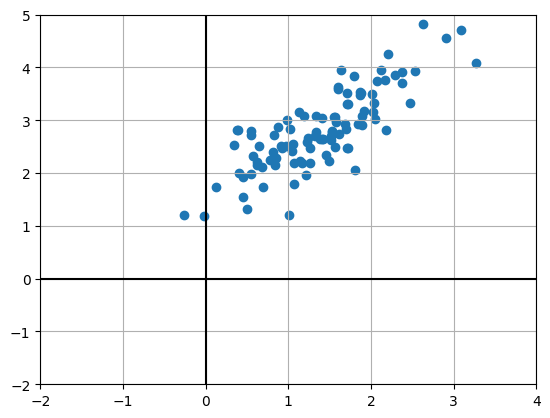

In [5]:
plt.scatter(data_rotated[:,0], data_rotated[:,1])
plt.xlim([-2, 4])
plt.ylim([-2, 5])
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid()
plt.show()

In [6]:
# Data for univariate regression
X = data_rotated[:,0].reshape(-1, 1)
y = data_rotated[:,1]

### Univariate / multivariate

--> Univariate regression or "simple" regression is when there is only one predictor.

--> Multivariate regression or "multiple" regression is when there is more than one predictors.

### Estimator

$$\hat \theta = (X^TX)^{-1}X^Ty$$

In [7]:
# estimator (scikit-learn)
print('**** Scikit-learn ****')
reg = LinearRegression().fit(X,y)
print('Intercept: {}'.format(reg.intercept_))
print('Coef: {}'.format(reg.coef_[0]))

# estimator (manual)
print('**** Manual ****')
# add a new column for intercept
X_ = np.zeros((n_observations, 2))
X_[:,0] = X.flatten()
X_[:,1] = 1
X_gram = np.linalg.inv(np.dot(X_.T, X_))
theta = np.dot(X_gram, np.dot(X_.T, y)) 
print('Intercept: {}'.format(theta[1]))
print('Coef: {}'.format(theta[0]))

**** Scikit-learn ****
Intercept: 1.5761217146791788
Coef: 0.8955747949177975
**** Manual ****
Intercept: 1.5761217146791933
Coef: 0.8955747949177876


### Coefficient of determination

$$R^2 = 1-\frac{\sum (y_i - \hat y_i)^2}{\sum (y_i - \overline y)^2}$$

We note that: 

$$R^2 = \frac{\sum (y_i - \overline y)^2 - \sum (y_i - \hat y_i)^2}{\sum (y_i - \overline y)^2} = \frac{\text{variance explained by the regression}}{\text{variance of }y}$$

We also have: $$R^2 = r_{y,\hat y}$$

Since the coefficient of determination also applies in the multivariate case, the metric is actually a more general use of the correlation coefficient.

In [8]:
y_pred = reg.intercept_ + reg.coef_*X.flatten()

In [9]:
RSS = ((y - y_pred)**2).sum()
TSS = ((y - y.mean())**2).sum()

In [10]:
R_2 = 1 - RSS/TSS
R_2

0.6917976611429277

In [11]:
np.corrcoef(y_pred, y)[0][1]**2

0.6917976611429273

In [12]:
reg.score(X,y)

0.6917976611429277

Problems with $R2$:

- It's a performance metric assessed on the *training data*. Thus it doesn't tell whether the algorithm generalizes well.
- $R2$ tends to drop when the variance is high. However, even if the variance is high, there can still be a strong linear relationship between the data.
- More generally, high $R2$ is not necessarily good and low $R2$ is not necessarily bad. Below is an example where $R2$ is very high for a non-linear relationship.

R2: 0.72


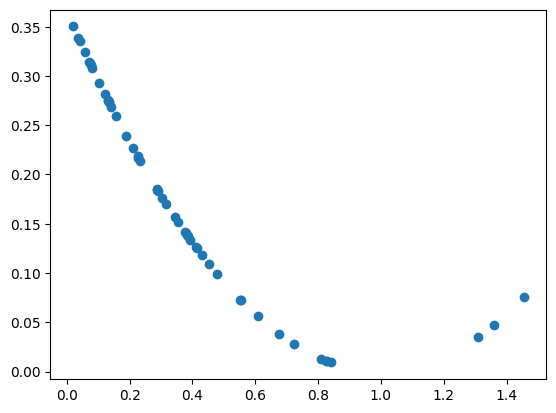

In [13]:
x2 = np.random.exponential(.4,50)
y2 = ((x2-1)**2)*np.random.uniform(low=0.3, high=1.2)
plt.scatter(x2, y2)

reg2 = LinearRegression().fit(x2.reshape(-1, 1),y2)
print('R2: {}'.format(round(reg2.score(x2.reshape(-1, 1),y2),2)))

### Intercept

In [14]:
np.mean(X.flatten())

1.4125489241596552

$X$ is not centered.

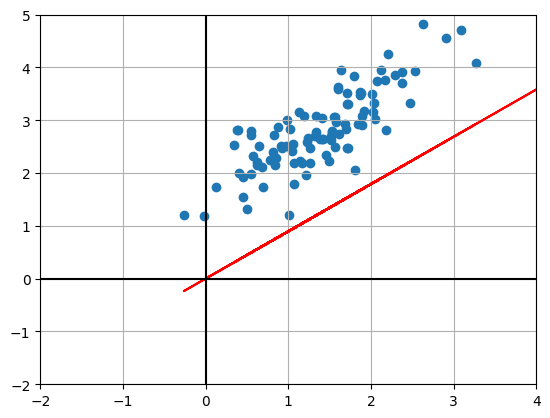

In [15]:
y_pred = reg.coef_*X.flatten()
plt.scatter(data_rotated[:,0], data_rotated[:,1])
plt.plot(X.flatten(), y_pred, 'r')
plt.xlim([-2, 4])
plt.ylim([-2, 5])
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid()
plt.show()

In [16]:
# R2
RSS = ((y - y_pred)**2).sum()
TSS = ((y - y.mean())**2).sum()
1 - RSS/TSS

-3.3760998655834884

Very bad $R2$.

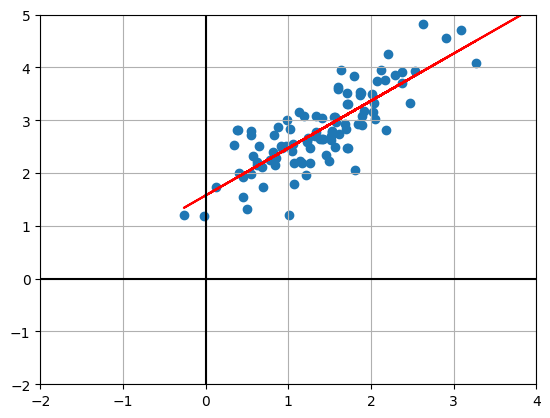

In [17]:
y_pred = reg.intercept_ + reg.coef_*X.flatten()
plt.scatter(data_rotated[:,0], data_rotated[:,1])
plt.plot(X.flatten(), y_pred, 'r')
plt.xlim([-2, 4])
plt.ylim([-2, 5])
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid()
plt.show()

In [18]:
# R2
RSS = ((y - y_pred)**2).sum()
TSS = ((y - y.mean())**2).sum()
1 - RSS/TSS

0.6917976611429277

Better $R^2$ when centering the data.

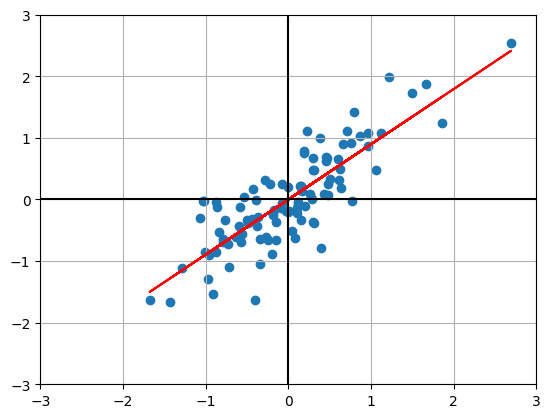

In [19]:
X_centered = X.flatten()-X.mean()
y_centered = y - y.mean()
y_pred = reg.coef_*X_centered
plt.scatter(X_centered, y_centered)
plt.plot(X_centered.flatten(), y_pred, 'r')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid()
plt.show()

In [20]:
# R2
RSS = ((y_centered - y_pred)**2).sum()
TSS = ((y_centered - y_centered.mean())**2).sum()
1 - RSS/TSS

0.6917976611429277

Centered data without intercept <=> uncentered data with intercept

**If data are not centered, we need to use intercept.**

### Predictions

In [21]:
# Scikit learn
print(reg.predict(X)[:10])
# Manual
print(reg.intercept_ + np.dot(X, reg.coef_)[:10])

[3.62308459 2.91234022 2.59308365 3.70036485 2.7757673  3.39029714
 2.45228815 2.06410851 2.94251458 3.40637565]
[3.62308459 2.91234022 2.59308365 3.70036485 2.7757673  3.39029714
 2.45228815 2.06410851 2.94251458 3.40637565]


### Assumptions

*Gauss-Markov theorem*:

OLS estimator is BLUE (Best Linear Unbiased Estimator = unbiased and lowest variance) if:

Errors need to:

- be uncorrelated

- have constant variance (homoscedasticity)

- have an expectation value of zero

$$\epsilon = y - \hat y$$

In [22]:
res = y - (theta[1] + X.T*theta[0])

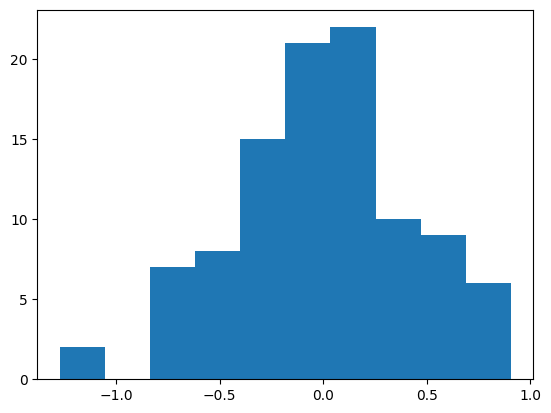

In [23]:
plt.hist(res.flatten())
plt.show()

##### Assumption 1: errors have constant variance (homoscedasticity)

In [53]:
np.random.seed(2)
df_data_heterosc = pd.DataFrame()
df_data_heterosc['constant'] = np.ones(data_rotated.shape[0])
df_data_heterosc['x'] = data_rotated[:,0]
df_data_heterosc['y'] = data_rotated[:,1]
df_data_heterosc = df_data_heterosc.sort_values(by='x').reset_index()

# we introduce a random noise with a trend
df_data_heterosc['y_2'] = df_data_heterosc\
                    .apply(lambda x: x['y']+x.name**1.1/100*np.random.normal(0,1), axis=1)

White’s Lagrange Multiplier Test for Heteroscedasticity: 

$$\mathcal{H}_0: \text{there is homoscedasticity}$$

*No heteroscedasticity*

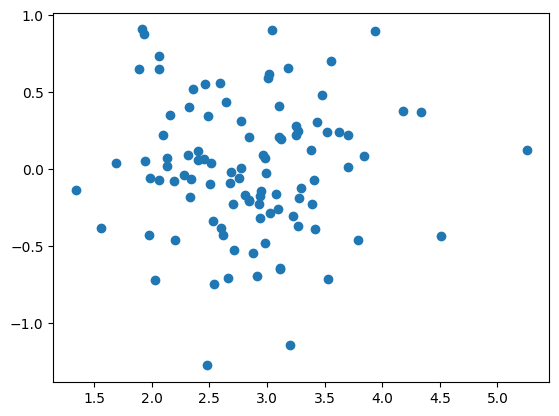

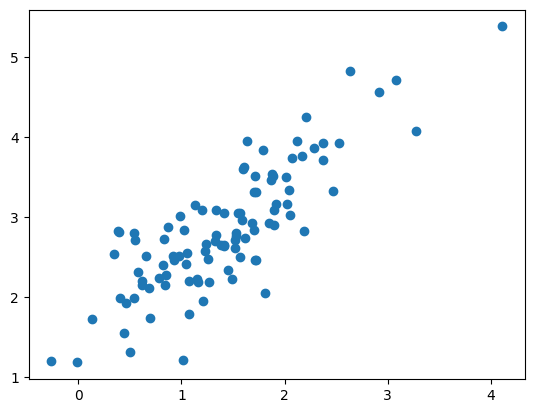

In [54]:
# best way to detect heteroscedasticity
plt.scatter(results.fittedvalues, results.resid) # => no clear trend => homoscedasticity
plt.show()

# other way to detect heteroscedasticity (less reliable because focuses on one predictor only)
plt.scatter(df_data_heterosc['x'], df_data_heterosc['y'])
plt.show()

In [48]:
model = sm.OLS(df_data_heterosc['y'], df_data_heterosc[['constant','x']])
results = model.fit()
het_white(results.resid, df_data_heterosc[['constant','x']])[1] # no heteroscedasticity

0.9106764743468577

*Heteroscedasticiy*

In [58]:
model = sm.OLS(df_data_heterosc['y_2'], df_data_heterosc[['constant','x']])
results = model.fit()

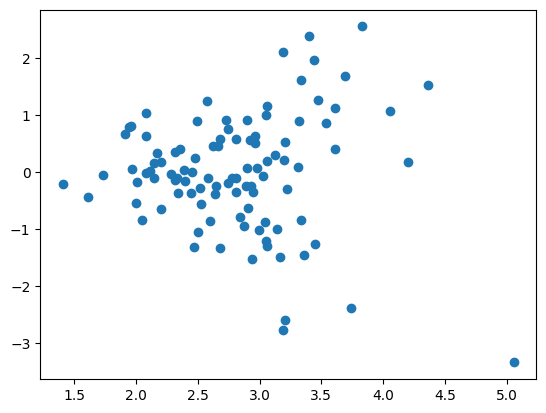

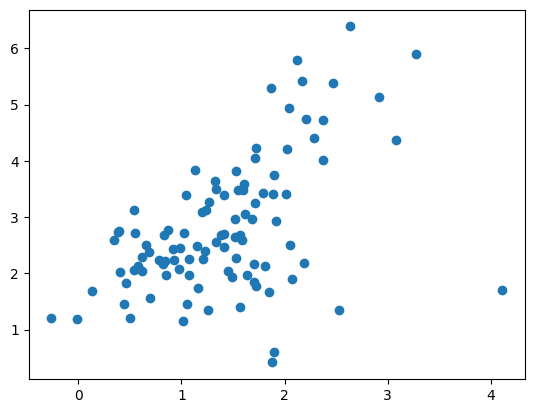

In [60]:
# best way to detect heteroscedasticity
plt.scatter(results.fittedvalues, results.resid) # => trend => heteroscedasticity
plt.show()

# other way to detect heteroscedasticity (less reliable because focuses on one predictor only)
plt.scatter(df_data_heterosc['x'], df_data_heterosc['y_2'])
plt.show()

In [61]:
het_white(results.resid, df_data_heterosc[['constant','x']])[1] # heteroscedasticity!

1.4951293612415148e-09

If heteroscedasticity, the estimator is not necessarily the best (Gauss-Markov conditions are not satistifed). Indeed, the <font color='red'>estimator does not have the lowest variance</font> anymore. In other words, the estimator becomes quite unstable.

Below is an illustration of the estimator unstability when changing the data.

In [76]:
for i in range(3):
    np.random.seed(i)
    df_data_heterosc = pd.DataFrame()
    df_data_heterosc['constant'] = np.ones(data_rotated.shape[0])
    df_data_heterosc['x'] = data_rotated[:,0]
    df_data_heterosc['y'] = data_rotated[:,1]
    df_data_heterosc = df_data_heterosc.sort_values(by='x').reset_index()
    df_data_heterosc['y_2'] = df_data_heterosc\
                        .apply(lambda x: x['y']+x.name**1.1/100*np.random.normal(0,1), axis=1)
    model = sm.OLS(df_data_heterosc['y_2'], df_data_heterosc[['constant','x']])
    results = model.fit()
    het_white(results.resid, df_data_heterosc[['constant','x']])[1] # heteroscedasticity!
    print('run {}: coefficient={}'.format(i,results.params.iloc[1]))

run 0: coefficient=1.1128824679242977
run 1: coefficient=0.9908172904194349
run 2: coefficient=0.8354583160610898


##### Assumption 2: no correlation between the error and the exploratory variables (exogeneity)

$$\mathbb{E}[\epsilon | X]=0$$

This means that the errors do not depend on X. This assumption is needed to make sure there is no important variable missing that may also explain the relationship. 

Put it differently, Y has no effect on X (?).

Endogeneity: 
- important variable is omitted
- omitted variable is correlated with one or several explanatory variables
- omitted variable is correlated with the dependent variable (= contributes to explain the result)

=> <font color='red'>estimator is biased</font>

We consider the following true (linear) model that gives the price of a car:

$$price = 20000-2000*Age-0.01*Kms$$

Other interesting example: https://statisticsbyjim.com/regression/confounding-variables-bias/ (bone density explained by activity and weights).

<img src='omitted-variable.png' width='300px'></img>

The omitted variable is the Age.

In [30]:
data_population = pd.DataFrame(data={
    'price':[8000,10000,10500,12500,13000,15000,15500,17500],
    'age':[5,4,4,3,3,2,2,1],
    'kms':[200000,200000,150000,150000,100000,100000,50000,50000],
    'rdm':[0,0,0,0,0,0,0,0]
})

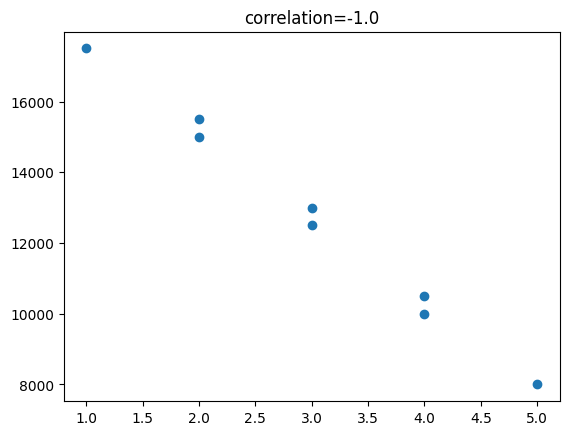

In [31]:
plt.scatter(data_population['age'],data_population['price'])
plt.title('correlation={}'.format(round(np.corrcoef(x=data_population['age'], y=data_population['price'])[0][1],2)))
plt.show()

In [32]:
X_population = data_population[['age','kms']]
y_population = data_population['price']
lr_true = LinearRegression().fit(X_population,y_population)
error = y_population-\
    (lr_true.intercept_ +\
     lr_true.coef_[0]*X_population['age'] +\
     lr_true.coef_[1]*X_population['kms']) # "true" error

In [33]:
data_sample = data_population[data_population.index.isin([0,1,2,4,6])]
X_sample = data_sample[['kms','age']]
y_sample = data_sample['price']
lr_sample = LinearRegression().fit(np.array(X_sample['kms']).reshape(-1, 1),y_sample)
residual = y_sample-\
    (lr_sample.intercept_ +\
     lr_sample.coef_[0]*X_sample['kms'])

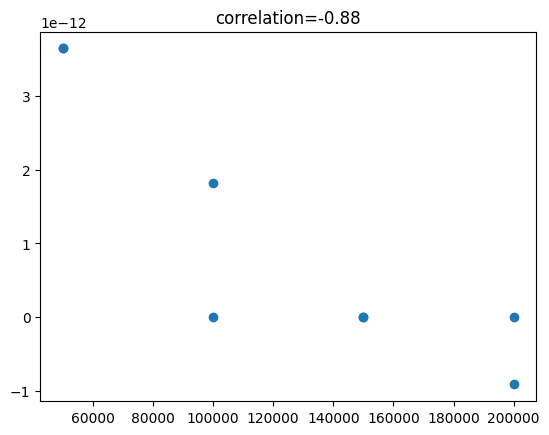

In [34]:
plt.scatter(X_population['kms'],error)
plt.title('correlation={}'.format(round(np.corrcoef(x=X_population['kms'], y=error)[0][1],2)))
plt.show()

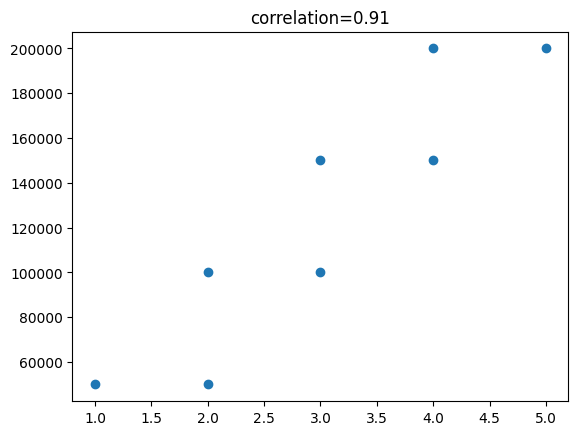

In [35]:
plt.scatter(data_population['age'],data_population['kms'])
plt.title('correlation={}'.format(round(np.corrcoef(x=data_population['age'], y=data_population['kms'])[0][1],2)))
plt.show()

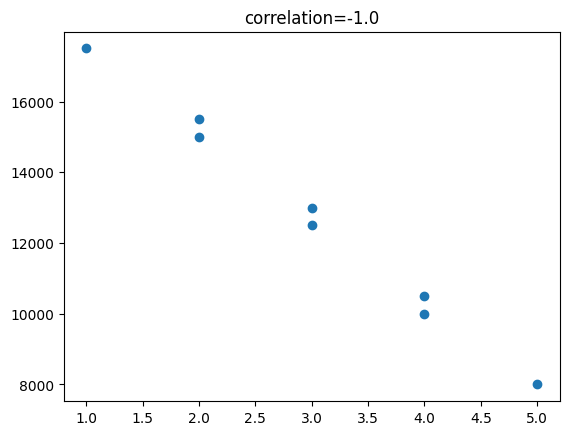

In [36]:
plt.scatter(data_population['age'],data_population['price'])
plt.title('correlation={}'.format(round(np.corrcoef(x=data_population['age'], y=data_population['price'])[0][1],2)))
plt.show()

The omitted variable is correlated to:
- the independent variable
- the dependent variable (=> it also explains the result)
- the error (=> it is "hidden" in the error)

=> endogeneity.

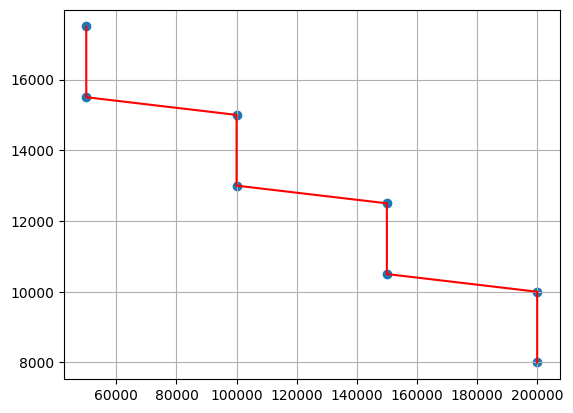

In [37]:
y_pred_true = lr_true.intercept_ + lr_true.coef_[0]*X_population['age'] + lr_true.coef_[1]*X_population['kms']
plt.scatter(X_population['kms'], y_population)
plt.plot(X_population['kms'], y_pred_true, 'r')
plt.grid()
plt.show()

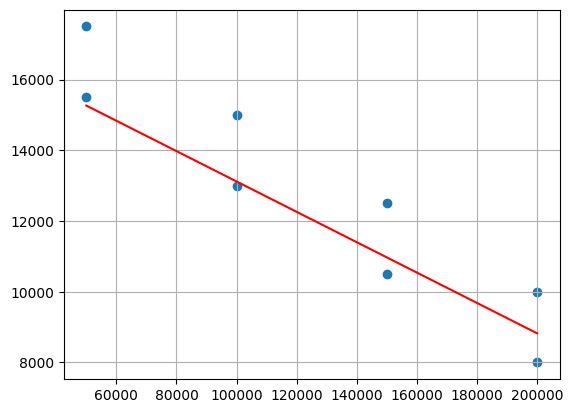

In [38]:
y_pred = lr_sample.intercept_ + lr_sample.coef_[0]*X_sample['kms']
plt.scatter(X_population['kms'], y_population)
plt.plot(X_sample['kms'], y_pred, 'r')
plt.grid()
plt.show()

The estimator is **biased**. Intuitively, if the true model is built on Age and Kms but we only consider Kms, obviously the estimation is biased since it uses **part** of the rules.

Note: a biased estimator can have the effect of either underestimate the relationship **or** overestimate the relationship.

To detect omitted variables and if all variables are available, try out several combinations of independent variables. If the coefficients change, there is an omitted variable:

In [39]:
print(LinearRegression().fit(np.array(data_sample['kms']).reshape(-1,1), y_sample).coef_[0])
print(LinearRegression().fit(data_sample[['kms','age']], y_sample).coef_[0])
print(LinearRegression().fit(data_sample[['kms','age','rdm']], y_sample).coef_[0])

-0.04294117647058824
-0.010000000000000009
-0.010000000000000009


We can see that when removing/adding Age, the coefficients strongly change => Age should be included in the model.

However when adding the RDM it doesn't change => Rdm shouldn't be included in the model.

##### Assumption 3: the errors are uncorrelated

When errors are correlated, the variance is not minimal anymore.

$$\begin{align*}
  Cov(\widehat{\theta}) &= \mathbb{V}[(X^TX)^{-1}X^TY] \\
            &= \mathbb{V}[(X^TX)^{-1}X^T(X \theta^* + \epsilon)] \\
	   &= 0 + ((X^TX)^{-1}X^T)^T\mathbb{V}[\epsilon] (X^TX)^{-1}X^T \\
	   &> (X^TX)^{-1}\sigma^2 ~~~~\text{ since $X^TX$ is symmetric}
\end{align*}$$

Reminder: $\mathbb{V}[\epsilon] = \mathbb{E}[\epsilon^T \epsilon]$ when $\mathbb{E}[\epsilon]=0$

### Multivariate example 

In [41]:
df = pd.read_csv('./Econometrics/data_projet_MS/HPRICE3.raw', delim_whitespace=True, header=None)

/var/folders/5d/vly6rwbn3n13_76f6p037kjr0000gn/T/ipykernel_54143/4183525518.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('./Econometrics/data_projet_MS/HPRICE3.raw', delim_whitespace=True, header=None)


In [42]:
df.shape

(321, 19)

In [43]:
price = df[7]/100
age = df[1]
nbh = df[3]
inst = df[5]
rooms = df[8]
area = df[9]
land = df[10]
baths = df[11]
dist = df[12]
y81 = df[15]

In [44]:
X_home = np.column_stack((age,nbh,inst,rooms,area,land,baths,dist,y81))
y_home = price
# Scikit learn
reg_home = LinearRegression().fit(X_home, y_home)
print(reg_home.intercept_)
print(reg_home.coef_)

# Manual
const = np.ones(np.shape(price))
X_home_const = np.column_stack((const,age,nbh,inst,rooms,area,land,baths,dist,y81))
X_gram = np.linalg.inv(np.dot(X_home_const.T, X_home_const))
theta = np.dot(X_gram, np.dot(X_home_const.T, y_home)) 
print(theta)

-211.14276727779668
[-2.28878493e+00 -1.98891522e+01 -5.40056344e-03  4.13147513e+01
  2.17429764e-01  1.21874610e-03  1.30025473e+02  5.05836600e-03
  3.58654274e+02]
[-2.11142767e+02 -2.28878493e+00 -1.98891522e+01 -5.40056344e-03
  4.13147513e+01  2.17429764e-01  1.21874610e-03  1.30025473e+02
  5.05836600e-03  3.58654274e+02]


In [45]:
# Statsmodel
model = sm.OLS(y_home, X_home_const)
results = model.fit()
print(results.summary())

s=y81==0 # prix moyen des maisons en 78
p0=np.mean(price[s])
s=y81==1 # prix moyen des maisons en 81
p1=np.mean(price[s])
print(p1-p0)

                            OLS Regression Results                            
Dep. Variable:                      7   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     86.73
Date:                Mon, 06 Jan 2025   Prob (F-statistic):           2.14e-79
Time:                        22:53:25   Log-Likelihood:                -2201.6
No. Observations:                 321   AIC:                             4423.
Df Residuals:                     311   BIC:                             4461.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -211.1428    105.234     -2.006      0.0

*Residuals*

In [46]:
y_home-(reg_home.intercept_+np.dot(X_home, reg_home.coef_))

0      166.095540
1     -255.639839
2       77.930895
3      304.295116
4       35.210462
          ...    
316   -210.619723
317      9.310803
318     -2.880461
319     53.206644
320    639.064852
Name: 7, Length: 321, dtype: float64

In [47]:
# Using residuals as dependent variable may be useful to understand what drive the variance
u = results.resid
u2 = u**2
model = sm.OLS(u2, X_home_const)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     13.53
Date:                Mon, 06 Jan 2025   Prob (F-statistic):           2.57e-18
Time:                        22:53:31   Log-Likelihood:                -4234.7
No. Observations:                 321   AIC:                             8489.
Df Residuals:                     311   BIC:                             8527.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.307e+04   5.93e+04      0.389      0.6